In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
#import functools
#import multiprocessing
#from joblib import Parallel, delayed, pool
#from joblib.pool import has_shareable_memory
import numba

## change in velocity
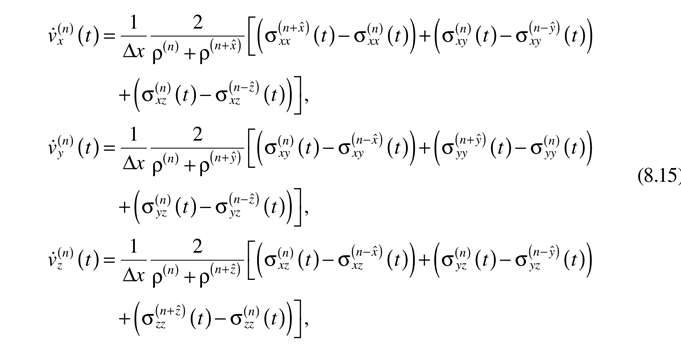

## change in stress
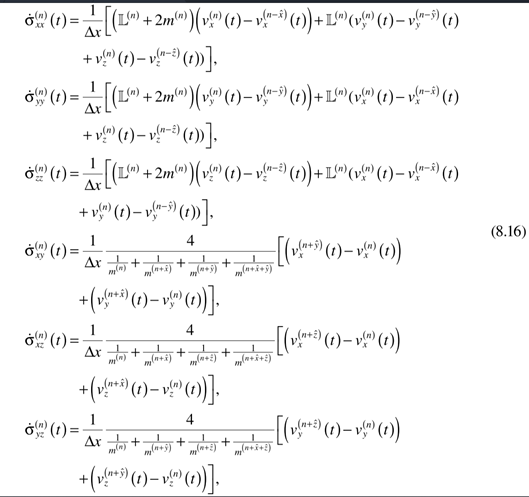

## update rules
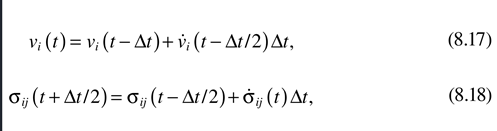

## Boundary Conditions
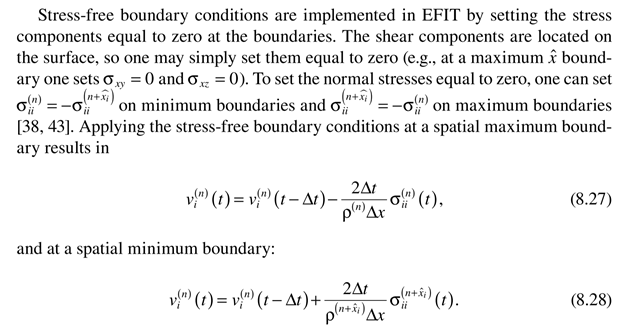

## Stability Conditions
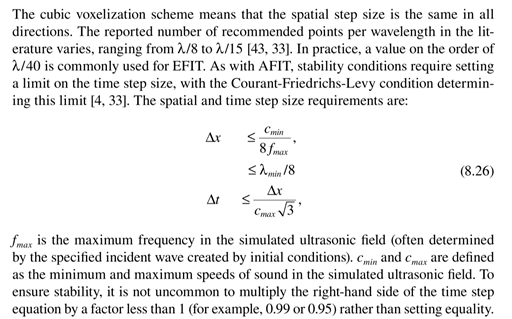

## General Procedure 

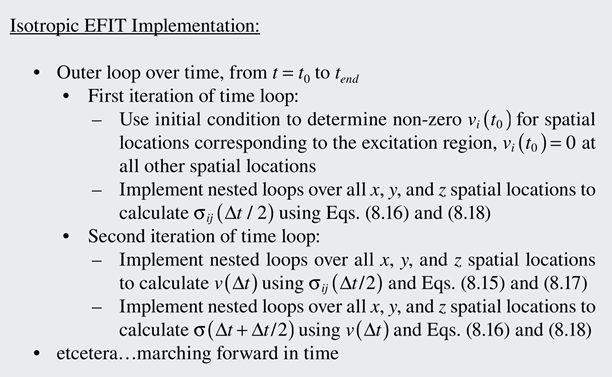

In [2]:
# set Constants

#MATERIAL 1 (concrete)
pRatio1 = 0.15                                     #poission's ratio in 
yModulus1 = 24 * (10**9)                           #youngs modulus in pascals
rho1 = 2400                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter


#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

print('material 1 wave speeds:' ,cl1,ct1)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency




#MATERIAL 2 (iron)
pRatio2=0.3
yModulus2= 200*(10**9)
rho2 = 7800       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = 2 * mu2 * pRatio2 / (1 - 2 * pRatio2)     

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency


#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2
#diensions of material 1 

length1 = 0.30
width1 = 0.30
height1 = 0.150

#dimensions for material 2

length2= 0.1
width2= 0.1
height2= 0.15



material 1 wave speeds: 3249.462449572256 2085.144140570748
material 2 wave speeds: 5875.097044815179 3140.3714651066384


In [3]:
#Run for 6 Cycles:
runtime = 7.5 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.95 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) *2       #length 
gw1 = int(math.ceil(width1 / gs)) *2        #width
gh1 = int(math.ceil(height1 / gs)) *2       #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl1, gw1,gh1)


runtime (s), time step size (s), total # of time steps: 0.0001875 4.055484798772039e-07 464
grid step size, # of length pts, # of height pts, # of width pts: 0.004344050292855724 140 140 70


In [4]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#defining where the 2nd material lies in the grid
#for now we'll simulate a square rod of material 2 in the middle of a block 
#made up of material 1

gl2 = int(math.ceil(length2 / gs))       
gw2 = int(math.ceil(width2 / gs))         
gh2 = int(math.ceil(height2 / gs))

for x in range(gl1):
    for y in range(gw1):
        if x < y:
            matProps[0,x,y,:]=rho2
            matProps[1,x,y,:]=lmbda2
            matProps[2,x,y,:]=mu2

print('Total # of grid pts, # of material 1 pts, # of material 2 pts:', [gl1*gw1*gh1, gl1*gw1*gh1-8*gl2*gw2*gh2, 8*gl2*gw2*gh2])
print('material 2 indices:')
print('x:',[int(gl1/2)-gl2, int(gl1/2)+gl2])
print('y:',[int(gw1/2)-gw2, int(gw1/2)+gw2])
print('z:', [0, gh2*2])

Total # of grid pts, # of material 1 pts, # of material 2 pts: [1372000, 1210720, 161280]
material 2 indices:
x: [46, 94]
y: [46, 94]
z: [0, 70]


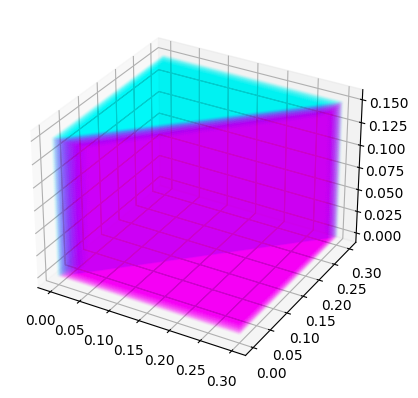

In [5]:
#3D scatter plot of grid pts to show geometry 
#of the 2 materials

x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matProps[0,:,:,:]

plt.figure()


ax=plt.axes(projection='3d')

fig=ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')

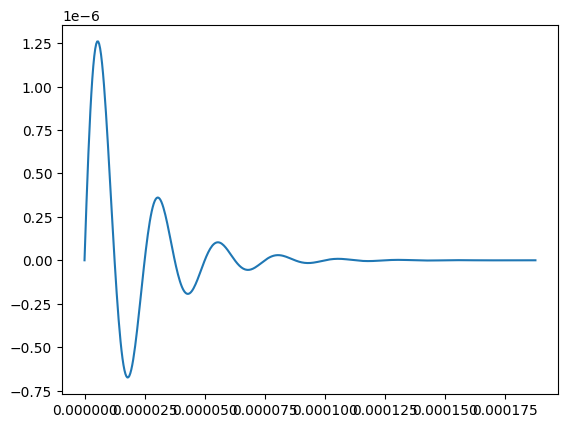

In [6]:
#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 50000
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

plt.plot(timeVec,sinInputSignal)

plt.ioff()

In [7]:
#boundary values 
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

#initialize fields
vx=np.zeros((gl1,gw1,gh1))
vy=np.zeros((gl1,gw1,gh1))
vz=np.zeros((gl1,gw1,gh1))

sxx=np.zeros((gl1,gw1,gh1))
syy=np.zeros((gl1,gw1,gh1))
szz=np.zeros((gl1,gw1,gh1))
sxy=np.zeros((gl1,gw1,gh1))
sxz=np.zeros((gl1,gw1,gh1))
syz=np.zeros((gl1,gw1,gh1))

#record the signal at a specified location
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)


In [8]:
Points = []
for x in range(gl1):
    for y in range(gw1):
        for z in range(gh1):
            Points.append([x,y,z])


In [9]:
def updateStress(x,y,z):
    
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])

    if x!=0 and x!=xmax and y!=0 and y!=ymax:
        shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)

    if x!=0 and x!=xmax and z!=0 and z!=zmax:

        shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)

    if y!=0 and y!=ymax and z!=0 and z!=zmax:

        shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)

    #FACES
    if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        dsxy=ds*ts
        del shearxy

        dsxz=0
        dsyz=0

    elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:


        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        dsyz=ds*ts
        del shearyz

    elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:
        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        dsyz=ds*ts
        del shearyz

    elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        dsxz=ds*ts
        del shearxz

        dsyz=0

    elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        dsxz=ds*ts
        del shearxz

        dsyz=0

    elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        dsxy=ds*ts
        del shearxy

        dsxz=0
        dsyz=0


    #EDGES
    #bottom edges
    elif x==0 and y!=0 and y!=ymax and z==0:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y!=0 and y!=ymax and z==0:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0


    elif x!=0 and x!=xmax and y==0 and z==0:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]
        
        dsxy=0
        dsxz=0
        dsyz=0


    elif x!=0 and x!=xmax and y==ymax and z==0:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    #side edges
    elif x==0 and y==0 and z!=0 and z!=zmax:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0
        dsyz=0


    elif x==xmax and y==0 and z!=0 and z!=zmax:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==0 and y==ymax and z!=0 and z!=zmax:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0
        dsyz=0


    elif x==xmax and y==ymax and z!=0 and z!=zmax:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        dsxy=0
        dsxz=0
        dsyz=0


    #top edges
    elif x==0 and y!=0 and y!=ymax and z==zmax:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y!=0 and y!=ymax and z==zmax:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x!=0 and x!=xmax and y==0 and z==zmax:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0


    elif x!=0 and x!=xmax and y==ymax and z==zmax:


        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0


    #CORNERS

    elif x==0 and y==0 and z==0:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==0 and y==0 and z==zmax:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==0 and y==ymax and z==0:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==0 and y==ymax and z==zmax:

        dsxx=-sxx[x+1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y==0 and z==0:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y==0 and z==zmax:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y+1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y==ymax and z==0:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z+1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    elif x==xmax and y==ymax and z==zmax:

        dsxx=-sxx[x-1,y,z]-sxx[x,y,z]

        dsyy=-syy[x,y-1,z]-syy[x,y,z]

        dszz=-szz[x,y,z-1]-szz[x,y,z]

        dsxy=0
        dsxz=0
        dsyz=0

    #NORMAL UPDATE
    else:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        dsxx=ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        dsyy=ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        dszz=ds*ts

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        dsxy=ds*ts

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        dsxz=ds*ts   

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        dsyz=ds*ts

    #delete variables for updates
    del norm1, norm2

    return dsxx, dsyy, dszz, dsxy, dsxz, dsyz

def UpdateStresses():
    for x in range(gl1):
        for y in range(gw1):
            for z in range(gh1):
                dsxx, dsyy, dszz, dsxy, dsxz, dsyz = updateStress(x,y,z)
                sxx[x,y,z] += dsxx
                syy[x,y,z] += dsyy
                szz[x,y,z] += dszz
                sxy[x,y,z] += dsxy
                sxz[x,y,z] += dsxz
                syz[x,y,z] += dsyz
    return 0


In [10]:
def updateVelocity(x,y,z):
    # setup delta grids
    #dvx = np.ones(np.shape())
    
    #calculate constants for velocity
    if x!=xmax:
        dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
        vminx=(2*ts)/(matProps[0,x+1,y,z]*gs)

    if y!=ymax:
        dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
        vminy=(2*ts)/(matProps[0,x,y+1,z]*gs)

    if z!=zmax:
        dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
        vminz=(2*ts)/(matProps[0,x,y,z+1]*gs)


    vmax=(2*ts)/(matProps[0,x,y,z]*gs)



    #FACES
    if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]


    elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts                     


    elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts


        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]



    #EDGES
    #bottom edges
    elif x==0 and y!=0 and y!=ymax and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y!=0 and y!=ymax and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x!=0 and x!=xmax and y==0 and z==0:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x!=0 and x!=xmax and y==ymax and z==0:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    #side edges
    elif x==0 and y==0 and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif x==xmax and y==0 and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif x==0 and y==ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts



    elif x==xmax and y==ymax and z!=0 and z!=zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    #top edges
    elif x==0 and y!=0 and y!=ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif x==xmax and y!=0 and y!=ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x!=0 and x!=xmax and y==0 and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif x!=0 and x!=xmax and y==ymax and z==zmax:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    #CORNERS
    elif x==0 and y==0 and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==0 and y==0 and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==0 and y==ymax and z==0:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==0 and y==ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==xmax and y==0 and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y==0 and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif x==xmax and y==ymax and z==0:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif x==xmax and y==ymax and z==zmax:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    else:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

        del dvxConst, dvyConst, dvzConst


In [11]:
stime = time.time()
jobs = 15

for t in range(0,Tsteps):
    
       
    #sin-exponential input
    vz[inputx,inputy,inputz]=vz[inputx,inputy,inputz]-szzConst*szz[inputx,inputy,inputz]+sinInputSignal[t]
    
    
    #update Stresses
    UpdateStresses()

    for i in Points:
        updateVelocity(i[0],i[1],i[2])
        
    
    #record signals
    vxSignal[t]=vx[signalLocx,signalLocy,signalLocz]
    vySignal[t]=vy[signalLocx,signalLocy,signalLocz]
    vzSignal[t]=vz[signalLocx,signalLocy,signalLocz]
    
    #save vx cut figure
    if t%10==0:
        fig=plt.figure()
        plt.contourf(np.transpose(vz[:,:,int(gh1/2)]), cmap='seismic')
        plt.savefig('vzmidCut'+str(t)+'.png')
        plt.close(fig)
    
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)), time.time()-stime)

0 / 463 checksums vx, sxx: 0.0 0.0 23.141205549240112
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032977 45.941306829452515
2 / 463 checksums vx, sxx: 2.611830437428823e-07 10.010300769892616 68.54424929618835
3 / 463 checksums vx, sxx: 4.962114298621675e-07 18.642198120336857 91.23374700546265
4 / 463 checksums vx, sxx: 7.451916119829191e-07 27.664702690187884 114.11856627464294
5 / 463 checksums vx, sxx: 8.953412323064187e-07 37.475562076601214 136.96490097045898
6 / 463 checksums vx, sxx: 1.0199692161037352e-06 42.34994509348952 160.58828592300415
7 / 463 checksums vx, sxx: 1.2571903362290255e-06 51.7614430934357 183.79771518707275
8 / 463 checksums vx, sxx: 1.3803742922622214e-06 62.268516887549325 206.79886388778687
9 / 463 checksums vx, sxx: 1.5316567910975229e-06 72.35195986211725 229.99841356277466
10 / 463 checksums vx, sxx: 1.7427194099001265e-06 80.30081598933658 252.85969710350037
11 / 463 checksums vx, sxx: 1.9085178111721043e-06 89.73105263885677 275.541

KeyboardInterrupt: 

3 loops and functions
0 / 463 checksums vx, sxx: 0.0 0.0 42.54019045829773
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 85.9329047203064
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 129.34246444702148
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 172.73137998580933
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 216.12839102745056

1 loop and functions
0 / 463 checksums vx, sxx: 0.0 0.0 43.41779279708862
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 87.03242444992065
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 130.67627906799316
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 174.14996218681335
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 217.67327785491943

code in series
0 / 463 checksums vx, sxx: 0.0 0.0 49.54623055458069
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 98.71403884887695
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 148.13409042358398
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 197.24465084075928
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 246.56837677955627

10 parallel tasks sharing variables shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 263.45540499687195
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 517.9381580352783

1 parallel task sharing variables shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 973.7282524108887
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 1892.5281636714935

20 parallel task shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 203.8962342739105220 
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 410.43651604652405

30 parallel shared mem
0 / 463 checksums vx, sxx: 0.0 0.0 434.80657958984375
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 873.0215351581573
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 1293.599306344986
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 1773.760350227356
4 / 463 checksums vx, sxx: 7.451916119829184e-07 24.236309080842403 2213.5885384082794

10 parallel no share
0 / 463 checksums vx, sxx: 0.0 0.0 273.3588342666626
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 524.6249568462372
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 776.7317447662354
3 / 463 checksums vx, sxx: 4.962114298621673e-07 16.513254316159664 1084.5888712406158

20 parallel no share
0 / 463 checksums vx, sxx: 0.0 0.0 216.18960332870483
1 / 463 checksums vx, sxx: 1.4461247396879636e-07 3.6247134562032968 442.9726667404175
2 / 463 checksums vx, sxx: 2.6118304374288224e-07 10.010300769892615 636.7484667301178


In [ ]:
plt.contourf(np.transpose(vz[:,:,15]), cmap='seismic')

In [ ]:
plt.plot(vxSignal)
plt.show()

In [ ]:
plt.plot(vySignal)
plt.show()

In [ ]:
plt.plot(vzSignal)
plt.show()

In [ ]:
# make animated gif from saved EFIT figures

import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/efitAnim.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)
    

In [ ]:
frame_folder='figs'

make_gif(frame_folder)